# Exploring Cell Coverage of Routes
* To do later: move data sources to a catalog
* An agency here is defined: as a service and an operator...

In [216]:
# Read in zip files
import fsspec

# Other
import geopandas as gpd
import numpy as np
import pandas as pd
import shared_utils
from calitp import *

# Display
from IPython.display import HTML, Image, Markdown, display, display_html

# Geometry
from shared_utils import geography_utils

os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

In [72]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [73]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

## California County Borders

In [74]:
ca_gdf = gpd.read_file(
    "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
)

## Trip Routes 

In [116]:
routes_df = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/traffic_ops/ca_transit_routes.parquet"
)

In [117]:
routes_df["route_type"].value_counts()

3    7397
2     183
0     119
4      57
5      31
1       4
Name: route_type, dtype: int64

In [118]:
routes_subset = routes_df[["route_type", "route_name", "agency"]]

In [119]:
cols_without_geometry = [
    "agency",
    "route_name",
    "itp_id",
    "route_id",
    "shape_id",
    "route_type",
]

In [120]:
# Drop Amtrak
routes_df2 = routes_df.loc[routes_df["agency"] != "Amtrak"]

In [121]:
# Filter for only bus routes
routes_df2 = routes_df.loc[routes_df["route_type"] == "3"]

In [122]:
# Drop Bay Area Ferry Service - ferry only
# routes_df2 = routes_df2.loc[routes_df2["agency"] != "San Francisco Bay Ferry"]

In [124]:
f"{len(routes_df2)} rows left after dropping - compared to {len(routes_df)} rows before."

'7397 rows left after dropping - compared to 7791 rows before.'

In [125]:
# Fill in NA for route names and agency names
routes_df2[["agency", "route_name"]] = routes_df2[["agency", "route_name"]].fillna(
    "None"
)

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
# Keep only one instance of a unique ITP ID - Route ID - Route Type combination
routes_df3 = routes_df2.drop_duplicates(subset=["itp_id", "route_id", "route_type"])

In [127]:
# Keep only one instance of a unique ITP ID - route_name combo
routes_df3 = routes_df3.drop_duplicates(subset=["itp_id", "route_name"])

In [128]:
# Reset index after dropping
routes_df3 = routes_df3.reset_index()

In [129]:
f"{routes_df2.route_id.nunique()} unique route ids, {routes_df2.route_name.nunique()} different route names, and {routes_df2.shape_id.nunique()} different shape ids."

'1657 unique route ids, 1857 different route names, and 5764 different shape ids.'

In [130]:
routes_df3.shape

(2223, 8)

## FCC AT&T Data Map 
* Testing with AT&T first.

### Clip AT&T map to only include California Counties

In [131]:
"""
# Open zip file first
PATH = f"{GCS_FILE_PATH}ATT_Mobility_LTE_Data.zip"
with fsspec.open(PATH) as file:
    fcc_gdf = gpd.read_file(file)
    
# Check that they are the same CRS
fcc_gdf.crs == ca_gdf.crs

# Clip 
fcc_ca_gdf = gpd.clip(fcc_gdf, ca_gdf)

# Save this into a parquet so don't have to clip all the time
utils.geoparquet_gcs_export(fcc_ca_gdf, GCS_FILE_PATH, 'AT_T_Data_California_Only')
"""

'\n# Open zip file first\nPATH = f"{GCS_FILE_PATH}ATT_Mobility_LTE_Data.zip"\nwith fsspec.open(PATH) as file:\n    fcc_gdf = gpd.read_file(file)\n    \n# Check that they are the same CRS\nfcc_gdf.crs == ca_gdf.crs\n\n# Clip \nfcc_ca_gdf = gpd.clip(fcc_gdf, ca_gdf)\n\n# Save this into a parquet so don\'t have to clip all the time\nutils.geoparquet_gcs_export(fcc_ca_gdf, GCS_FILE_PATH, \'AT_T_Data_California_Only\')\n'

In [132]:
# Open
fcc_ca_gdf = gpd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/cellular_coverage/AT_T_Data_California_Only.parquet"
)

In [133]:
# fcc_ca_gdf.plot(figsize = (30,12))

## Overlay 
* I want to obtain routes that are NOT contained in the AT & T coverage map.
* https://geopandas.org/en/stable/docs/user_guide/set_operations.html

In [134]:
# Check that they are the same CRS
fcc_ca_gdf.crs == routes_df3.crs

True

In [135]:
# Reproject
fcc_ca_gdf = fcc_ca_gdf.to_crs("epsg:3395")
routes_df3 = routes_df3.to_crs("epsg:3395")

In [136]:
overlay_df = routes_df3.overlay(fcc_ca_gdf, how="difference")

In [137]:
overlay_df.shape

(395, 8)

<AxesSubplot:>

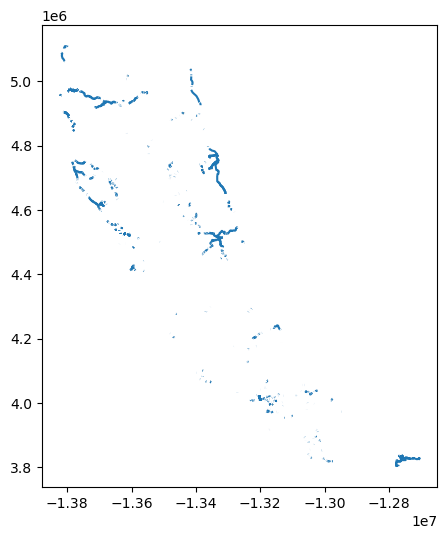

In [138]:
# Change to overlay later
(overlay_df.plot(figsize=(12, 6), markersize=30))

In [139]:
display(
    Markdown(
        f"""There are {overlay_df['route_id'].nunique()} routes (run by {overlay_df['agency'].nunique()} different agencies) 
        w/o overlap to the AT&T coverage map. In comparison, there are {routes_df2.route_id.nunique()} total routes in the original dataframe."""
    )
)

There are 284 routes (run by 94 different agencies) 
        w/o overlap to the AT&T coverage map. In comparison, there are 1657 total routes in the original dataframe.

In [140]:
# Previewing the routes left
# overlay_df[cols_without_geometry].sort_values('route_name')

In [141]:
# Agencies with the most routes without coverage.
(
    overlay_df.groupby(["agency"])
    .agg({"route_id": "nunique"})
    .rename(columns={"route_id": "total_routes"})
    .sort_values("total_routes", ascending=False)
    .head(10)
)

,total_routes
agency,
AC Transit,34
Metro,30
Marin Transit,18
Los Angeles Department of Transportation,13
San Diego Metropolitan Transit System,10
Tahoe Transportation,9
North County Transit District,9
Golden Gate Bridge Highway and Transportation District,9
Yuma County Area Transit,9


In [142]:
# Surprised by AC Transit
# overlay_df.loc[overlay_df['agency']=='AC Transit']

In [143]:
# List for unique itp_ids
agencies_no_coverage = overlay_df["itp_id"].unique().tolist()

In [144]:
# List for unique route ids
routes_no_coverage = overlay_df["route_id"].unique().tolist()

In [145]:
# List for unique route ids
routes_no_coverage_name = overlay_df["route_name"].unique().tolist()

In [146]:
# A table with all the itp id & agencies
agency_df = overlay_df[["agency", "itp_id"]].drop_duplicates().reset_index()

In [147]:
# Subset of overlap without geometry
overlay_df_no_geo = overlay_df[
    ["itp_id", "route_id", "shape_id", "route_type", "route_name", "agency"]
]

In [175]:
overlay_df.head(2)

,index,itp_id,route_id,shape_id,route_type,geometry,route_name,agency
0,9,4,19,shp-19-64,3,"MULTILINESTRING ((-13606584.699 4520702.360, -13606584.699 4520702.360, -13606598.169 4520681.045, -13606610.637 4520661.132, -13606624.218 4520639.816, -13606637.687 4520618.501, -13606642.474 4520611.069), (-13611657.279 4523618.700, -13611649.291 4523636.752, -13611639.049 4523659.898, -13611628.808 4523682.903, -13611618.678 4523706.048, -13611608.437 4523729.053, -13611598.195 4523752.198, -13611588.065 4523775.344, -13611577.824 4523798.349, -13611567.582 4523821.495, -13611557.452 4523844.640, -13611547.211 4523867.646, -13611536.969 4523890.792, -13611526.505 4523913.797, -13611516.041 4523936.662, -13611505.577 4523959.668, -13611495.002 4523982.674, -13611484.538 4524005.539, -13611475.632 4524025.178, -13611475.632 4524025.178))",Buena Vista - Fruitvale,AC Transit
1,15,4,20,shp-20-03,3,"LINESTRING (-13607283.118 4521084.084, -13607283.118 4521084.084, -13607296.810 4521062.908, -13607309.166 4521043.836, -13607323.638 4521023.080, -13607333.434 4521009.056)",Dimond - Fruitvale - South Shore,AC Transit


## Trips
* How many trips are running for a route?

In [195]:
trips_df = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/rt_delay/compiled_cached_views/trips_2022-05-04_all.parquet"
)

In [196]:
trips_df.shape

(104934, 14)

In [197]:
trips_df.head(1)

,calitp_itp_id,calitp_url_number,service_date,trip_key,trip_id,route_id,direction_id,shape_id,calitp_extracted_at,calitp_deleted_at,route_short_name,route_long_name,route_desc,route_type
0,4,0,2022-05-04,1582047897989018365,272020,21,1,shp-21-23,2022-03-26,2099-01-01,21,Dimond - Fruitvale - Bay Farm,None,3


In [198]:
# Add agency name
trips_df = pd.merge(
    trips_df, agency_df, how="inner", left_on="calitp_itp_id", right_on="itp_id"
)

In [199]:
# Try to standardize route id
overlay_df["route_id"] = overlay_df["route_id"].str.lower().str.strip()
trips_df["route_id"] = trips_df["route_id"].str.lower().str.strip()

In [200]:
# Filter out for route IDS
trips_df2 = trips_df[trips_df["route_id"].isin(routes_no_coverage)]

In [201]:
# So many route ids disappeared
f'{trips_df2["route_id"].nunique()} routes left after filtering trips_df compared to {len(routes_no_coverage)} routes in overlay.'

'188 routes left after filtering trips_df compared to 284 routes in overlay.'

In [202]:
# Checking which ones are missing.
id_routes = set(routes_no_coverage)
id_trips = set(trips_df2.route_id.unique().tolist())

In [203]:
missing_routes = list(id_routes - id_trips)

In [204]:
f"{len(missing_routes)/len(routes_no_coverage)}% of routes missing"

'0.3380281690140845% of routes missing'

In [205]:
# overlay_df_no_geo[overlay_df_no_geo["route_id"].isin(missing_routes)]

In [206]:
trips_ran = (
    trips_df2.groupby(["calitp_itp_id", "route_long_name", "agency"])
    .agg({"trip_id": "count"})
    .reset_index()
    .rename(columns={"trip_id": "total_trips"})
)

In [209]:
trips_ran.shape

(551, 4)

In [249]:
trips_ran.head(3)

,calitp_itp_id,route_long_name,agency,total_trips
0,4,14th St - San Antonio - High St,AC Transit,124
1,4,Alameda Pt. - 14th Ave. - Dimond,AC Transit,66
2,4,Alvarado - Castro Valley - B St.,AC Transit,34


In [246]:
trips_ran['agency'].nunique()

76

## NTD 

In [207]:
f"{stops_df2.route_id.nunique()} route ids in trip stops dataframe compared to {overlay_df.route_id.nunique()} route ids in the routes dataframe above...strange."

NameError: name 'stops_df2' is not defined

In [ ]:
# What the missing route ids?
routes_df_id = set(route_id_without_cell)

# Use original trip_stops df to find ids...do they even exist there?
trips_df_id = set(stops_df.route_id.unique().tolist())
routes_df_id - trips_df_id

In [ ]:
subset_stops = stops_df2[["agency", "stop_id", "stop_name", "route_name"]]

In [ ]:
total_stops_df = stops_df2.groupby(
    [
        "agency",
        "route_name",
    ]
).agg({"stop_name": "count"})

In [ ]:
len(total_stops_df)

In [220]:
ntd_df = pd.read_excel(
    f"gs://calitp-analytics-data/data-analyses/5311 /2020-Vehicles_1.xlsm",
    sheet_name="Vehicle Type Count by Agency",
)

In [232]:
# ntd_df.columns

In [233]:
# Only get bus related columns
columns_wanted = [
    "Agency",
    "City",
    "State",
    "Bus",
    'Over-The-Road Bus',
    "Articulated Bus",
    "Double Decker Bus",
    "School Bus",
]

In [234]:
ntd_df2 = to_snakecase(ntd_df[columns_wanted])

In [238]:
ntd_df2['total_buses'] = ntd_df2.sum(numeric_only = True, axis =1)

In [240]:
ntd_df2.sample(5)

,agency,city,state,bus,over_the_road_bus,articulated_bus,double_decker_bus,school_bus,total_buses
628,"Columbus Consolidated Government, dba: Metra Transit System",Columbus,GA,29,0,0,0,0,29
1973,City of South Pasadena,South Pasadena,CA,0,0,0,0,0,0
270,"City of Modesto, dba: Modesto Area Express",Modesto,CA,57,4,0,0,0,61
1762,Thurston Regional Planning Council,Olympia,WA,0,0,0,0,0,0
1751,COTA,Saipan,MP,0,0,0,0,0,0
